In [1]:
import io
import requests

import torch
import datasets

from utils import draw_pose, draw_pose_pil_center_crop
from clapp.model import CLaPPModel

/Users/clement/text-to-pose/.venv/lib/python3.11/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [22]:
dataset = datasets.load_dataset("clement-bonnet/coco_val2017_100_text_image_pose", split="test")
dataset

Dataset({
    features: ['file_name', 'license', 'coco_url', 'caption', 'id', 'pose'],
    num_rows: 100
})

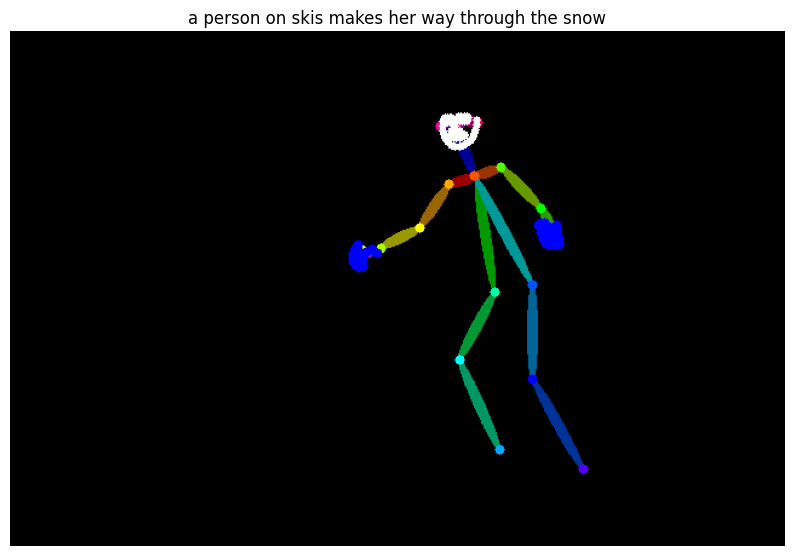

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

num_elements = 2
plt.figure(figsize=(10, 5*num_elements))

i = 0
file_name = dataset[i]["file_name"]
caption = dataset[i]["caption"]
response = requests.get(dataset[i]["coco_url"])
image = Image.open(io.BytesIO(response.content))

pose_image = Image.fromarray(draw_pose(dataset[i]["pose"], height=image.height, width=image.width))

plt.imshow(pose_image)
plt.axis("off")
plt.title(caption);

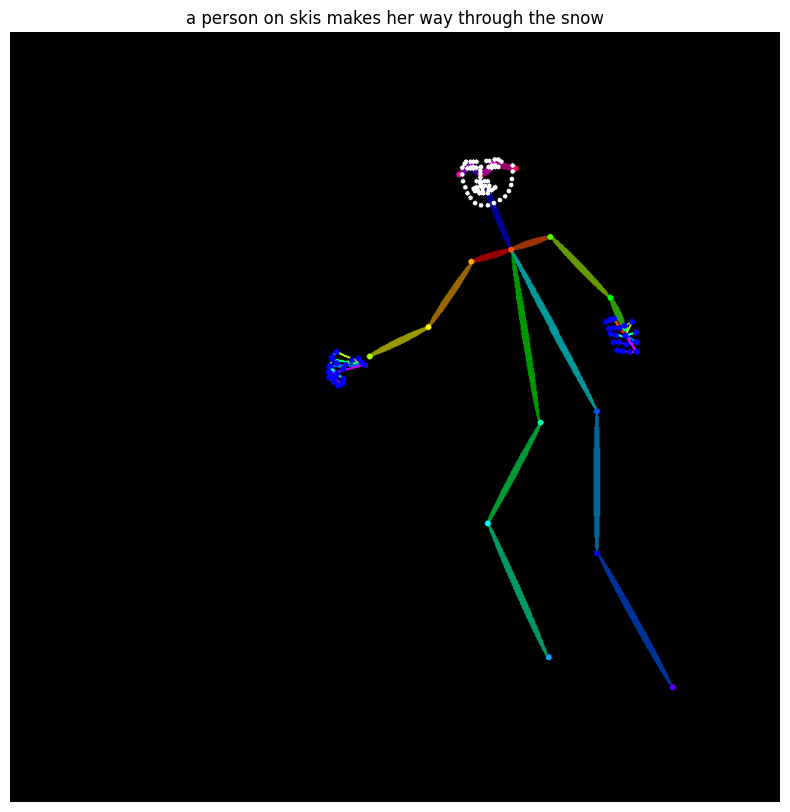

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

num_elements = 2
plt.figure(figsize=(10, 5*num_elements))

i = 0
file_name = dataset[i]["file_name"]
caption = dataset[i]["caption"]
response = requests.get(dataset[i]["coco_url"])
image = Image.open(io.BytesIO(response.content))
pose_image = draw_pose_pil_center_crop(dataset[i]["pose"], pose_hw_ratio=image.height / image.width)

plt.imshow(pose_image)
plt.axis("off")
plt.title(caption);

In [5]:
clapp_model = CLaPPModel.from_pretrained("clement-bonnet/clapp-v0").eval()

In [6]:
from tqdm.auto import trange
import numpy as np

coco_scores = []
for i in trange(100):
    caption = dataset[i]["caption"]
    response = requests.get(dataset[i]["coco_url"])
    image = Image.open(io.BytesIO(response.content))
    pose_image = draw_pose_pil_center_crop(dataset[i]["pose"], pose_hw_ratio=image.height / image.width)
    with torch.no_grad():
        coco_scores.append(clapp_model.score(pose_image, caption).item())
print(np.mean(np.array(coco_scores)), np.std(np.array(coco_scores)))

  0%|          | 0/100 [00:00<?, ?it/s]

0.5979566982015967 0.1873063828467338


Number of parameters: 10,767,124


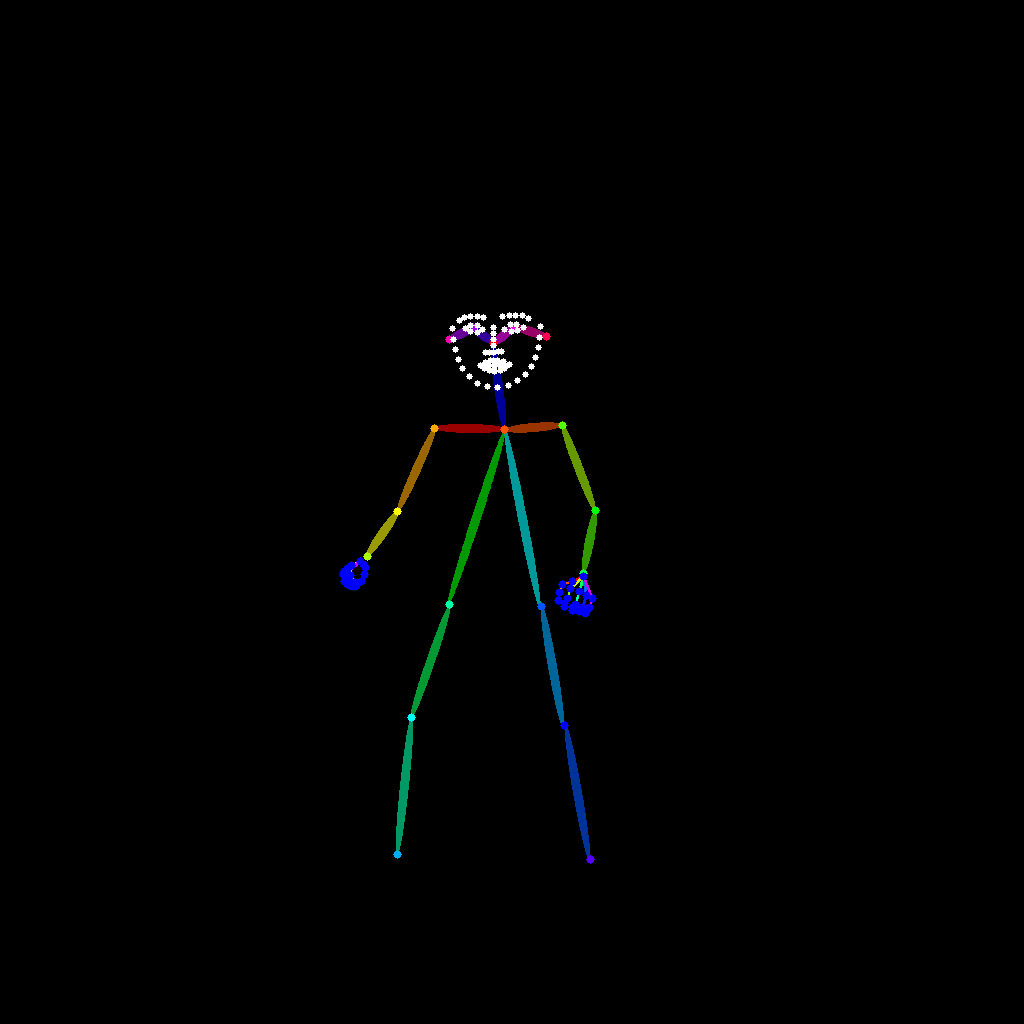

In [7]:
from PIL import Image
from transformers import AutoProcessor

from utils import draw_pose
from t2p.model import T2PTransformer

device = torch.device("cpu")
t2p_transformer = T2PTransformer.from_pretrained("clement-bonnet/t2p-transformer-v0")
t2p_transformer.to(device).eval()
print(
    "Number of parameters: {:,}".format(
        sum(p.numel() for p in t2p_transformer.parameters() if p.requires_grad)
    )
)

num_poses = 1
temperature = 0.1
image_ratio = 1.0

clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
with torch.no_grad():
    input_ids = clip_processor(
        text=caption, return_tensors="pt", padding="max_length", truncation=True
    )["input_ids"]
    text_embeddings = (
        t2p_transformer.clip_text_model(input_ids.to(device), output_hidden_states=True)
        .hidden_states[-2]
        .squeeze()
    )

poses = t2p_transformer.generate(
    text_embeddings=text_embeddings,
    num_poses=num_poses,
    bbox_dist_temperature=temperature,
    pose_dist_temperature=temperature,
    image_ratio=image_ratio,
)
dw_pose = t2p_transformer.convert_to_dwpose(poses)
generated_pose = Image.fromarray(draw_pose(dw_pose, 1024, int(1024 * image_ratio)))
generated_pose

In [8]:
with torch.no_grad():
    print(clapp_model.score(generated_pose, caption).item())

0.59521484375


In [9]:
def get_t2p_clapp_score(caption, num_poses=1, temperature=0.1, image_ratio=1.0):
    with torch.no_grad():
        input_ids = clip_processor(
            text=caption, return_tensors="pt", padding="max_length", truncation=True
        )["input_ids"]
        text_embeddings = (
            t2p_transformer.clip_text_model(input_ids.to(device), output_hidden_states=True)
            .hidden_states[-2]
            .squeeze()
        )

        poses = t2p_transformer.generate(
            text_embeddings=text_embeddings,
            num_poses=num_poses,
            bbox_dist_temperature=temperature,
            pose_dist_temperature=temperature,
            image_ratio=image_ratio,
        )
        dw_poses = t2p_transformer.convert_to_dwpose(poses)
        if num_poses == 1:
            dw_poses = [dw_poses]
        generated_poses = [Image.fromarray(draw_pose(dw_pose, 1024, int(1024 * image_ratio))) for dw_pose in dw_poses]
        clapp_scores = clapp_model.score(generated_poses, caption)
    return clapp_scores

In [10]:
t2p_scores = []
for i in trange(100):
    t2p_scores.append(get_t2p_clapp_score(dataset[i]["caption"], num_poses=3).mean().item())
print(np.array(t2p_scores).mean(), np.array(t2p_scores).std())

  0%|          | 0/100 [00:00<?, ?it/s]

0.6713597718067468 0.1752278533313082


---

# KNN

In [11]:
from clapp.clapp_dataset import CLaPPDataset
from t2p.knn_baseline import KNNClipTextToPose

In [31]:
import pickle

with open("knn_dataset_hashmap.pkl", "rb") as f:
    hashmap = pickle.load(f)

In [36]:
clapp_dataset = CLaPPDataset("clapp/data", split="train", split_ratio=1.0)
knn = KNNClipTextToPose(clapp_dataset)
knn_scores = []
for i in trange(100):
    caption = dataset[i]["caption"]
    input_ids = knn.clip_processor(text=caption, return_tensors="pt", truncation=True, padding=True)["input_ids"]
    text_features = knn.clip_model.get_text_features(input_ids.to(knn.device)).squeeze(0)
    distances = knn.compute_distance(text_features)
    _, indices = torch.topk(distances, 1, largest=False, sorted=True)
    keys = knn.dataset.keys[indices.cpu().numpy()]
    items = [knn.full_dataset[hashmap[key]] for key in keys]
    item = items[0]
    pose = item["poses"]
    width, height = item["size"]
    img_pose = draw_pose_pil_center_crop(pose, height / width)
    img_pose.save(f"knn_poses/pose_{i}.png")
    clapp_score = clapp_model.score(img_pose, caption).item()
    knn_scores.append(clapp_score)
print(np.array(knn_scores).mean(), np.array(knn_scores).std())

  0%|          | 0/53 [00:00<?, ?it/s]

0.3980560535658151 0.2957549800113568


---

In [38]:
num_wins_t2p = sum([t2p_score > knn_score for t2p_score, knn_score in zip(t2p_scores, knn_scores)])
num_wins_t2p

78

---

# Figure

/var/folders/6t/tj7tst354kz63t03mjhy5vnw0000gn/T/ipykernel_96413/1965499556.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["KNN", "T2P"], fontsize=14)


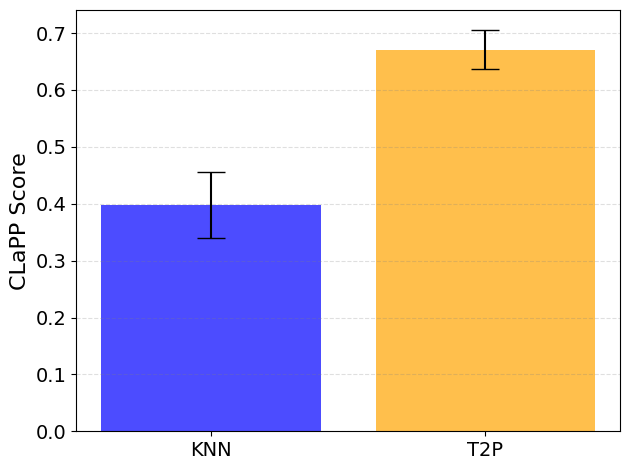

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
clapp_scores = [0.398, 0.671]
clapp_scores_std = [0.296, 0.175]
n = 100  # Sample size

# Calculate standard error
std_errors = [std / np.sqrt(n) for std in clapp_scores_std]

# Calculate the 95% confidence intervals
confidence_intervals = [1.96 * se for se in std_errors]

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(["KNN", "T2P"], clapp_scores, yerr=confidence_intervals, capsize=10, color=['blue', 'orange'], alpha=0.7)

# Add labels and title
ax.set_ylabel('CLaPP Score', fontsize=16)
ax.set_xticklabels(["KNN", "T2P"], fontsize=14)
# increase the size of the y-axis ticks
ax.tick_params(axis='y', labelsize=14)

# Add grid lines as dashed lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# Show the plot
plt.tight_layout()
plt.savefig('clapp_scores.pdf')
plt.show()